In [ ]:
%load_ext autoreload
%autoreload 2

In [20]:
from pathlib import Path
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()


In [2]:
# Potentiel solaire package
from potentiel_solaire.constants import DATA_FOLDER
from potentiel_solaire.features.roof_attributes import recuperation_mnh_batiment

In [ ]:
# Executer ci dessous ci besoin pour récupérer les données
# !extract-sample-data
# Et pour sauver une version markdown des notebooks, utiliser
# jupyter nbconvert wns_hauteur.ipynb --to markdown --output-dir=exports/

In [3]:


def getMesureMNSToit(row, cache_file="cache.gpkg", layercache="cache_hauteur",
                     valeur="hauteur_calculee"):

    values = ["hauteur_calculee", "hauteur_std-dev", "hauteur_min",
              "hauteur_max", "hauteur_median"]
    if valeur not in values:
        return -1
    row = gpd.GeoDataFrame(row).T
    row = gpd.GeoDataFrame(row, geometry="geometry")
    if "cleabs_left__bat" in row.columns:
        row = row.rename(columns={"cleabs_left__bat": "cleabs"})
    cache_h = DATA_FOLDER / cache_file

    if os.path.isfile(str(cache_h)):
        gdf = gpd.read_file(cache_h, layer=layercache)
        existing = gdf["cleabs"].unique()
    else:
        existing = []
    row = row[["cleabs", "hauteur", "geometry"]]

    cols = ["cleabs", "hauteur_calculee", "hauteur", "geometry",
            "hauteur_std-dev", "hauteur_min", "hauteur_max", "hauteur_median"]

    if row["cleabs"].iloc[0] in existing:
        v = gdf[gdf.cleabs == row["cleabs"].iloc[0]][valeur].iloc[0]
        return v
    else:
        mnh = recuperation_mnh_batiment(row)
        row["hauteur_calculee"] = np.average(mnh[np.nonzero(mnh)])
        row["hauteur_std-dev"] = np.std(mnh[np.nonzero(mnh)])
        row["hauteur_min"] = np.min(mnh[np.nonzero(mnh)])
        row["hauteur_max"] = np.max(mnh[np.nonzero(mnh)])
        row["hauteur_median"] = np.median(mnh[np.nonzero(mnh)])

        if len(existing):
            gtotal = pd.concat([gdf, row[cols]])
            gtotal.to_file(cache_h, layer=layercache, driver="GPKG")
        else:
            gtotal = row[cols]
            gtotal.to_file(cache_h, layer=layercache, driver="GPKG")

    return row[valeur]


#### Test sur les batiments de St Denis, qui n'ont pas de hauteur

In [4]:
saint_denis_path = DATA_FOLDER / "saint_denis_reference_data.gpkg"
batiments = gpd.read_file(saint_denis_path, layer="bdtopo_batiment").to_crs(2154)
batiments = batiments.to_crs(2154)

In [7]:
batiments_de_test = pd.concat([batiments[batiments.hauteur.isna()].head(50),batiments[~batiments.hauteur.isna()].head(50)])
for measure in ["hauteur_calculee", "hauteur_std-dev"]:
    batiments_de_test[measure] = \
        batiments_de_test.progress_apply(lambda batiment:\
        getMesureMNSToit(batiment, valeur=measure), axis = 1)
batiments_de_test[["cleabs_left__bat","hauteur","hauteur_calculee", "hauteur_std-dev"]]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 24.21it/s]


,cleabs_left__bat,hauteur,hauteur_calculee,hauteur_std-dev
3,BATIMENT0000000243403399,NaN,11.029757,0.067987
4,BATIMENT0000000243403625,NaN,6.658521,2.384741
9,BATIMENT0000000243399213,NaN,9.085352,3.031133
21,BATIMENT0000000243399192,NaN,15.689178,0.720638
22,BATIMENT0000000243399193,NaN,8.944949,3.632601
...,...,...,...,...
57,BATIMENT0000002005316846,8.8,8.908059,2.549423
58,BATIMENT0000000318256795,2.7,4.304110,3.272367
59,BATIMENT0000000243401942,9.3,10.166159,3.535393
60,BATIMENT0000000243401947,13.0,12.285078,2.676683


#### Les erreurs sont "elevées" sur les petits batiments, la précision est meilleure sur les plus grands bâtiments

In [ ]:
check = batiments_de_test[~batiments_de_test.hauteur.isna()]

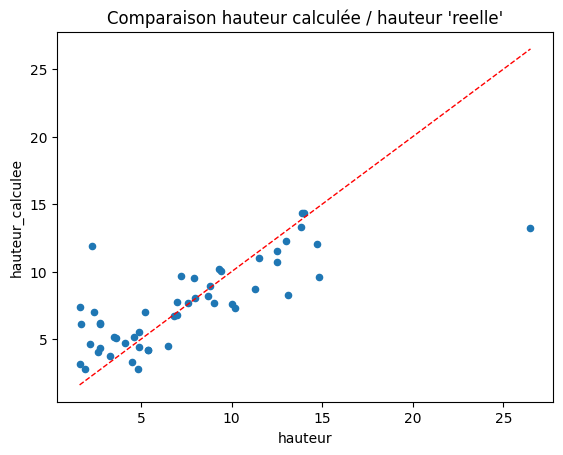

In [ ]:
identity_line = np.linspace(check.hauteur.min(),
                            check.hauteur.max())

check.plot.scatter(x="hauteur",y="hauteur_calculee",title="Comparaison hauteur calculée / hauteur 'reelle'")
plt.plot(identity_line, identity_line, color="red", linestyle="dashed", linewidth=1.0)

#### Représentation des erreurs

/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: title={'center': 'Erreur en fonction de la hauteur\nErreur sur les toits de plus de 5m: 16%'}, xlabel='hauteur', ylabel='difference'>

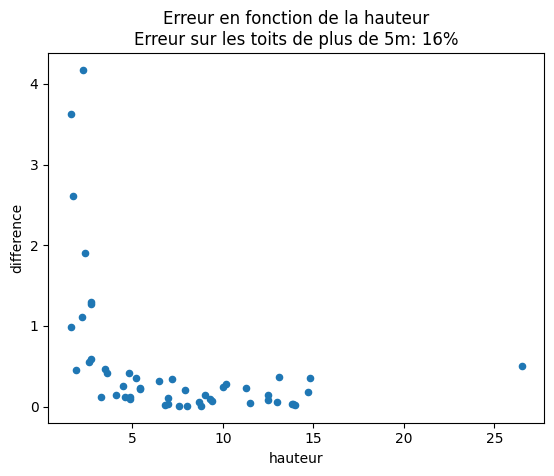

In [35]:
def getAccuracy(row):
    return np.abs(row["hauteur"]-row["hauteur_calculee"])/np.abs(row["hauteur"])
check["difference"] = check.apply(lambda batiment: getAccuracy(batiment), axis = 1)
detail = "Erreur sur les toits de plus de 5m: "+str(int(100*check["difference"][check.hauteur > 4 ].mean()))+"%"
check.plot.scatter(x="hauteur",y="difference",title="Erreur en fonction de la hauteur\n"+detail)

#### Test avec les pentes de toit

In [22]:
toits = gpd.read_file(saint_denis_path, layer="potentielsolaire_toitures").to_crs(2154)
toits = toits[toits.id.isin(check.cleabs_left__bat.unique())][["id","forme"]]
dataset_test = check[["cleabs_left__bat","hauteur_std-dev","hauteur_calculee"]]
dataset_test.columns = ["id","stdev","h"]
toits = toits.merge(dataset_test,on="id",how="inner")

#### test non concluant..

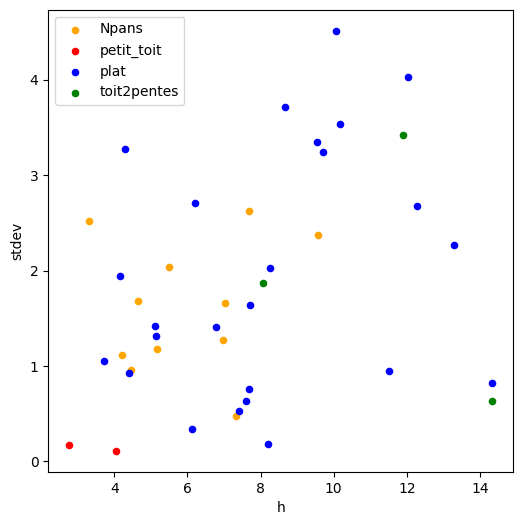

In [13]:
colors = {'plat':'blue', 'Npans':'orange', 'toit2pentes':'green', 'petit_toit':'red'}

fig, ax = plt.subplots(figsize=(6, 6))
grouped = toits.groupby('forme')
for key, group in grouped:
    group.plot.scatter(ax=ax, x='h', y='stdev', label=key, color=colors[key])
plt.show()